In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# read in data and simulated efficacy
data = pd.read_csv('as_lm_al_data.csv')
as_eff = pd.read_csv('am_ec50_efficacy.csv')
lm_eff = pd.read_csv('lm_ec50_efficacy.csv')
al_eff = pd.read_csv('al_ec50_efficacy.csv')

# head of data
print(data.head())

         PMID  START YEAR        PROVINCE     COUNTRY TREATMENT ARM  \
0  10403324.0      1996.0         Bangkok    Thailand            AL   
1  10403324.0      1996.0          Mae la    Thailand            AL   
2  11132386.0      1997.0  Bangkok Mae la    Thailand            AL   
3  11463111.0      1998.0         Bangkok    Thailand            AL   
4  15839740.0      2002.0       Farafenni  The Gambia            AL   

                             DOSAGE FOLLOW-UP TIME  n_total  n_cured  \
0  20 mg 120 mg 6 times over 3 days        28 days       29       27   
1  20 mg 120 mg 6 times over 3 days        28 days       67       66   
2  20 mg 120 mg 6 times over 3 days        28 days      134      131   
3  20 mg 120 mg 6 times over 3 days        28 days      155      148   
4                        20mg 120mg        28 days      347      333   

   efficacy PCR CORRECTED? (Y/N/UNCLEAR) PREGNANT? Y/N  STUDY TYPE  \
0  0.931034                            Y             N         NaN   


In [3]:
# head of simulated efficacy
print(as_eff.head())
print(lm_eff.head())
print(al_eff.head())

   ec50_am  efficacy
0     0.01    0.9988
1     0.03    0.9963
2     0.05    0.9939
3     0.07    0.9906
4     0.09    0.9894
   ec50_lm  efficacy
0     0.01    0.9953
1     0.03    0.9951
2     0.05    0.9936
3     0.07    0.9940
4     0.09    0.9923
   ec50_am  ec50_lm  efficacy
0     0.01     0.01       1.0
1     0.01     0.03       1.0
2     0.01     0.05       1.0
3     0.01     0.07       1.0
4     0.01     0.09       1.0


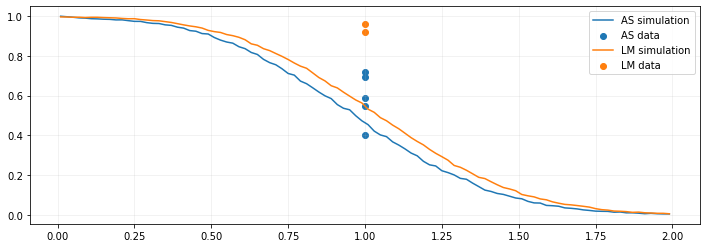

In [4]:
# figure
fig, ax = plt.subplots(figsize=(12, 4))

## plot AS mono
ax.plot(as_eff.ec50_am, as_eff.efficacy, label='AS simulation')
ax.scatter([1.0]* data[ data['TREATMENT ARM'] == 'AS' ].shape[0], data[ data['TREATMENT ARM'] == 'AS' ].loc[:,'efficacy'] ,label='AS data')

## plot LM mono
ax.plot(lm_eff.ec50_lm, lm_eff.efficacy, label='LM simulation')
ax.scatter([1.0]* data[ data['TREATMENT ARM'] == 'LM' ].shape[0], data[ data['TREATMENT ARM'] == 'LM' ].loc[:,'efficacy'] ,label='LM data')

## plot AL combo
# ax.plot(al_eff.ec50_am, al_eff.efficacy, label='AL simulation')
# ax.scatter([1.0]* data[ data['TREATMENT ARM'] == 'AL' ].shape[0], data[ data['TREATMENT ARM'] == 'AL' ].loc[:,'efficacy'] ,label='AL data')

ax.legend()
ax.grid(alpha=0.2)

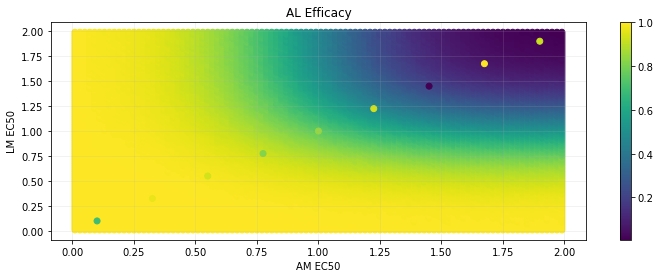

In [5]:
# plot al_eff: x = al_eff.ec50_am, y = al_eff.ec50_lm, heatmap color = al_eff.efficacy
fig, ax = plt.subplots(figsize=(12, 4))
ax.scatter(al_eff.ec50_am, al_eff.ec50_lm, c=al_eff.efficacy, cmap='viridis')

# scatter points at x = 1.0 and y = 1.0, color them by efficacy
ax.scatter(np.linspace(0.1, 1.9, data[ data['TREATMENT ARM'] == 'AL' ].shape[0]), np.linspace(0.1, 1.9, data[ data['TREATMENT ARM'] == 'AL' ].shape[0]), c=data[ data['TREATMENT ARM'] == 'AL' ].loc[:,'efficacy'] , cmap='viridis')

ax.set_xlabel('AM EC50')
ax.set_ylabel('LM EC50')
ax.set_title('AL Efficacy')
ax.grid(alpha=0.2)

# set colorbar visible
fig.colorbar(ax.collections[0])

## likelihood

In [6]:
# data gives efficacy, simulation gives efficacy given EC50; now we need to find the likelihood of the data given the simulation
# each data point has a total number of patients (n) and a number of successes (k)
# efficacy from data = k/n
# efficacy from simulation = p
# likelihood of data given simulation follows a binomial distribution
# likelihood = (n choose k) * p^k * (1-p)^(n-k)
# function to calculate likelihood
def likelihood(n, k, p):
    return (np.math.factorial(n) / (np.math.factorial(k) * np.math.factorial(n-k))) * (p**k) * ((1-p)**(n-k))

# instead of likelihood, we can use log likelihood to avoid underflow
# then, we can find the ec50 value that maximizes the log likelihood
# or equivalently, the ec50 value that minimizes the negative log likelihood
# function to calculate negative log likelihood
def neg_log_likelihood(n, k, p):
    return -np.log(likelihood(n, k, p) + 1e-10)

# we want to calculate the negative log likelihood for all data points given one ec50 value
# each ec50 value has a corresponding efficacy value from as_eff, this efficacy value is the probability of success
# function to calculate negative log likelihood for all AM data points given one ec50 value of AM
def neg_log_likelihood_am(ec50):
    # get efficacy value from as_eff
    p = as_eff[as_eff.ec50_am == ec50].efficacy.values[0]
    # get all data points with AM as treatment arm
    am_data = data[data['TREATMENT ARM'] == 'AM']
    # calculate negative log likelihood for each data point
    nll = [neg_log_likelihood(am_data.iloc[i].n_total, am_data.iloc[i].n_cured, p) for i in range(am_data.shape[0])]
    # return sum of all negative log likelihoods
    return sum(nll)

# function to calculate negative log likelihood for all LM data points given one ec50 value of LM
def neg_log_likelihood_lm(ec50):
    # get efficacy value from lm_eff
    p = lm_eff[lm_eff.ec50_lm == ec50].efficacy.values[0]
    # get all data points with LM as treatment arm
    lm_data = data[data['TREATMENT ARM'] == 'LM']
    # calculate negative log likelihood for each data point
    nll = [neg_log_likelihood(lm_data.iloc[i].n_total, lm_data.iloc[i].n_cured , p) for i in range(lm_data.shape[0])]
    # return sum of all negative log likelihoods
    return sum(nll)

# function to calculate negative log likelihood for all AL data points given one ec50 value of AM and one ec50 value of LM
def neg_log_likelihood_al(ec50_am, ec50_lm):
    # get efficacy value from al_eff
    p = al_eff[(al_eff.ec50_am == ec50_am) & (al_eff.ec50_lm == ec50_lm)].efficacy.values[0]
    # get all data points with AL as treatment arm
    al_data = data[data['TREATMENT ARM'] == 'AL']
    # calculate negative log likelihood for each data point
    nll = [neg_log_likelihood(al_data.iloc[i].n_total , al_data.iloc[i].n_cured , p) for i in range(al_data.shape[0])]
    # return sum of all negative log likelihoods
    return sum(nll)

# from scipy.optimize import minimize

# # find ec50 value that minimizes negative log likelihood for AM, bounds = (0.01, 1.99)
# am_ec50 = minimize(neg_log_likelihood_am, 1.0, method='Nelder-Mead', bounds=[(0.01, 1.99)]).x[0] 
# # find ec50 value that minimizes negative log likelihood for LM, bounds = (0.01, 1.99)
# lm_ec50 = minimize(neg_log_likelihood_lm, 1.0, method='Nelder-Mead', bounds=[(0.01, 1.99)]).x[0]
# # find ec50 value that minimizes negative log likelihood for AL, bounds = (0.01, 1.99) for both ec50_am and ec50_lm
# al_ec50 = minimize(neg_log_likelihood_al, [1.0, 1.0], method='Nelder-Mead', bounds=[(0.01, 1.99), (0.01, 1.99)]).x

In [7]:
# call neg_log_likelihood_am, neg_log_likelihood_lm, neg_log_likelihood_al with the ec50 values from as_eff, lm_eff, al_eff
sum_nll_am = [neg_log_likelihood_am(as_eff.iloc[i].ec50_am) for i in range(as_eff.shape[0])]
sum_nll_lm = [neg_log_likelihood_lm(lm_eff.iloc[i].ec50_lm) for i in range(lm_eff.shape[0])]
sum_nll_al = [neg_log_likelihood_al(al_eff.iloc[i].ec50_am, al_eff.iloc[i].ec50_lm) for i in range(al_eff.shape[0])]

In [11]:
# add sum_nll_al as a column to al_eff
al_eff['sum_nll_al'] = sum_nll_al
# add sum_nll_am as a column to al_eff based on the ec50_am value
al_eff['sum_nll_am'] = [sum_nll_am[as_eff[as_eff.ec50_am == al_eff.iloc[i].ec50_am].index[0]] for i in range(al_eff.shape[0])]
# add sum_nll_lm as a column to al_eff based on the ec50_lm value
al_eff['sum_nll_lm'] = [sum_nll_lm[lm_eff[lm_eff.ec50_lm == al_eff.iloc[i].ec50_lm].index[0]] for i in range(al_eff.shape[0])]
# add a column to al_eff that is the sum of sum_nll_am, sum_nll_lm, and sum_nll_al
al_eff['sum_nll'] = al_eff['sum_nll_am'] + al_eff['sum_nll_lm'] + al_eff['sum_nll_al']

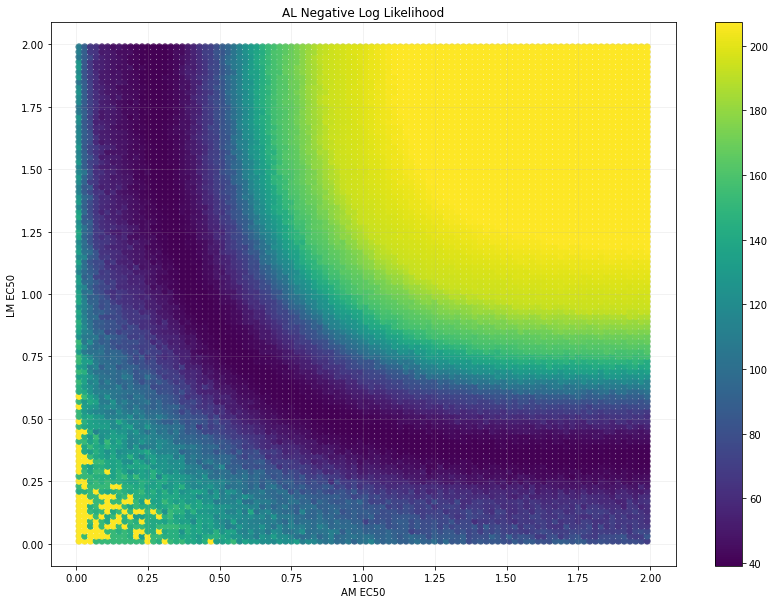

In [10]:
# plot negative log likelihood for AL as a function of ec50_am and ec50_lm
# x-axis = ec50_am, y-axis = ec50_lm, color = negative log likelihood
fig, ax = plt.subplots(figsize=(14, 10))
ax.scatter(al_eff.ec50_am, al_eff.ec50_lm, c=sum_nll_al, cmap='viridis')
ax.set_xlabel('AM EC50')
ax.set_ylabel('LM EC50')
ax.set_title('AL Negative Log Likelihood')
ax.grid(alpha=0.2)
# colorbar visible
fig.colorbar(ax.collections[0])

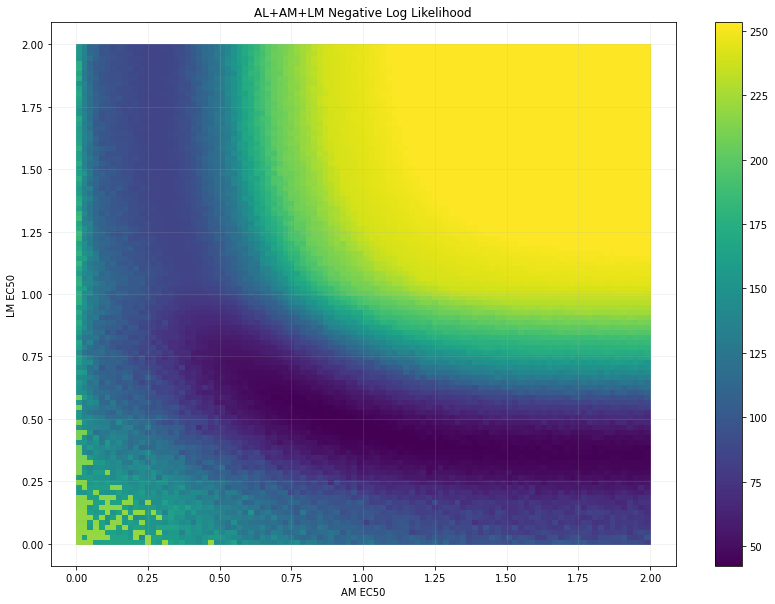

In [16]:
# plot negative log likelihood for AL as a function of ec50_am and ec50_lm
# x-axis = ec50_am, y-axis = ec50_lm, color = negative log likelihood
fig, ax = plt.subplots(figsize=(14, 10))
ax.scatter(al_eff.ec50_am, al_eff.ec50_lm, c=al_eff.sum_nll, cmap='viridis', marker='s')
ax.set_xlabel('AM EC50')
ax.set_ylabel('LM EC50')
ax.set_title('AL+AM+LM Negative Log Likelihood')
ax.grid(alpha=0.2)
# colorbar visible
fig.colorbar(ax.collections[0])

In [15]:
# save figure
fig.savefig('al_neg_log_likelihood.pdf', dpi=300, bbox_inches='tight')

In [14]:
# export al_eff to csv
al_eff.to_csv('al_efficacy_w_negative_log_likelihood.csv', index=False)